In [1]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster()
client = Client(cluster)
client

import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import cmocean.cm as cmo
from xmitgcm import open_mdsdataset


In [2]:
filename_state = 'diag_state'
filename_surf = 'diag_surf'

lon = 220.0
latMin = -0.1
latMax = 0.1

# data_dir = '/data/SO3/edavenport/tpose6/nov2012/run_iter0/'
data_dir = '/data/SO3/edavenport/tpose6/sep2012/velocity_withhold/run_iter14/'
grid_dir = '/data/SO6/TPOSE_diags/tpose6/grid_6/'

num_diags = 122 #
itPerFile = 72 # 1 day
intervals = range(itPerFile,itPerFile*num_diags+1,itPerFile)

prefix = [filename_state, filename_surf]
ds = open_mdsdataset(data_dir=data_dir,grid_dir=grid_dir,iters=intervals,prefix=prefix,ref_date='2012-09-01',delta_t=1200.,ignore_unknown_vars=True)

ds['XC'] = ds.XC.astype(float)
ds['YC'] = ds.YC.astype(float)
ds['Z'] = ds.Z.astype(float)
ds['XG'] = ds.XG.astype(float)
ds['YG'] = ds.YG.astype(float)
ds['Zl'] = ds.Zl.astype(float)

# data_dir = '/data/SO3/edavenport/tpose6/nov2012/run_iter0_noVelAssimIC/'
data_dir = '/data/SO3/edavenport/tpose6/sep2012/velocity_assim/run_iter22/'
grid_dir = '/data/SO6/TPOSE_diags/tpose6/grid_6/'

num_diags = 122 #
itPerFile = 72 # 1 day
intervals = range(itPerFile,itPerFile*num_diags+1,itPerFile)

prefix = [filename_state, filename_surf]
ds_vel = open_mdsdataset(data_dir=data_dir,grid_dir=grid_dir,iters=intervals,prefix=prefix,ref_date='2012-09-01',delta_t=1200.,ignore_unknown_vars=True)

ds_vel['XC'] = ds.XC.astype(float)
ds_vel['YC'] = ds.YC.astype(float)
ds_vel['Z'] = ds.Z.astype(float)
ds_vel['XG'] = ds.XG.astype(float)
ds_vel['YG'] = ds.YG.astype(float)
ds_vel['Zl'] = ds.Zl.astype(float)

# data_dir = '/data/SO3/edavenport/tpose6/nov2012/run_iter0_noVelAssimIC/'
data_dir = '/data/SO3/edavenport/tpose6/sep2012/velocity_assim/run_iter0/'
grid_dir = '/data/SO6/TPOSE_diags/tpose6/grid_6/'

num_diags = 122 #
itPerFile = 72 # 1 day
intervals = range(itPerFile,itPerFile*num_diags+1,itPerFile)

prefix = [filename_state, filename_surf]
ds_noTAO = open_mdsdataset(data_dir=data_dir,grid_dir=grid_dir,iters=intervals,prefix=prefix,ref_date='2012-09-01',delta_t=1200.,ignore_unknown_vars=True)

ds_noTAO['XC'] = ds.XC.astype(float)
ds_noTAO['YC'] = ds.YC.astype(float)
ds_noTAO['Z'] = ds.Z.astype(float)
ds_noTAO['XG'] = ds.XG.astype(float)
ds_noTAO['YG'] = ds.YG.astype(float)
ds_noTAO['Zl'] = ds.Zl.astype(float)

In [3]:
folder_name = '/home/edavenport/analysis/mitgcm-equatorial-waves/sst/'

In [12]:
sst = ds.THETA.sel(Z=[0.0],XC=[190.0,220.0,250.0],method='nearest').sel(YC=slice(latMin,latMax)).squeeze().mean(dim='YC').compute()

sst_vel = ds_vel.THETA.sel(Z=[0.0],XC=[190.0,220.0,250.0],method='nearest').sel(YC=slice(latMin,latMax)).squeeze().mean(dim='YC').compute()

sst_noTAO = ds_noTAO.THETA.sel(Z=[0.0],XC=[190.0,220.0,250.0],method='nearest').sel(YC=slice(latMin,latMax)).squeeze().mean(dim='YC').compute()

In [13]:
from scipy.signal import detrend
# detrend, get anomaly
sst_detrend = detrend(sst,axis=0,type='linear') 
sst_anom = sst_detrend - np.nanmean(sst_detrend,axis=0)
sst_vel_detrend = detrend(sst_vel,axis=0,type='linear') 
sst_vel_anom = sst_vel_detrend - np.nanmean(sst_vel_detrend,axis=0)
sst_noTAO_detrend = detrend(sst_noTAO,axis=0,type='linear')
sst_noTAO_anom = sst_noTAO_detrend - np.nanmean(sst_noTAO_detrend,axis=0)


## Basic FFT -> Power Spectrum

In [14]:
N = len(sst.time)
window = np.hanning(N)*np.ones((3,1))

sst_window = sst_anom*window.T
Fsst = np.fft.fft(sst_window,axis=0)
amp1 = abs(Fsst[:N//2,:]/N)
amp1[1:,:] = 2*amp1[1:,:]
freq_segments = 1/(np.arange(N//2)/N)

sst_vel_window = sst_vel_anom*window.T
Fsst = np.fft.fft(sst_vel_window,axis=0)
amp2 = abs(Fsst[:N//2,:]/N)
amp2[1:,:] = 2*amp2[1:,:]

sst_noTAO_window = sst_noTAO_anom*window.T
Fsst = np.fft.fft(sst_noTAO_window,axis=0)
amp3 = abs(Fsst[:N//2,:]/N)
amp3[1:,:] = 2*amp3[1:,:]


In [15]:
temp = sst[:len(freq_segments)].copy(deep=True)
temp.values = amp1
amp1 = temp
amp1['time'] = freq_segments
amp1['long_name'] = 'sst Power Spectrum'
amp1 = amp1.isel(time=slice(1,None)) # get rid of the zero frequency

temp = sst_vel[:len(freq_segments)].copy(deep=True)
temp.values = amp2
amp2 = temp
amp2['time'] = freq_segments
amp2['long_name'] = 'sst Vel Assim Power Spectrum'
amp2 = amp2.isel(time=slice(1,None)) # get rid of the zero frequency

temp = sst_noTAO[:len(freq_segments)].copy(deep=True)
temp.values = amp3
temp['time'] = freq_segments
temp['long_name'] = 'sst No TAO Power Spectrum'
amp3 = temp
amp3 = amp3.isel(time=slice(1,None)) # get rid of the zero frequency


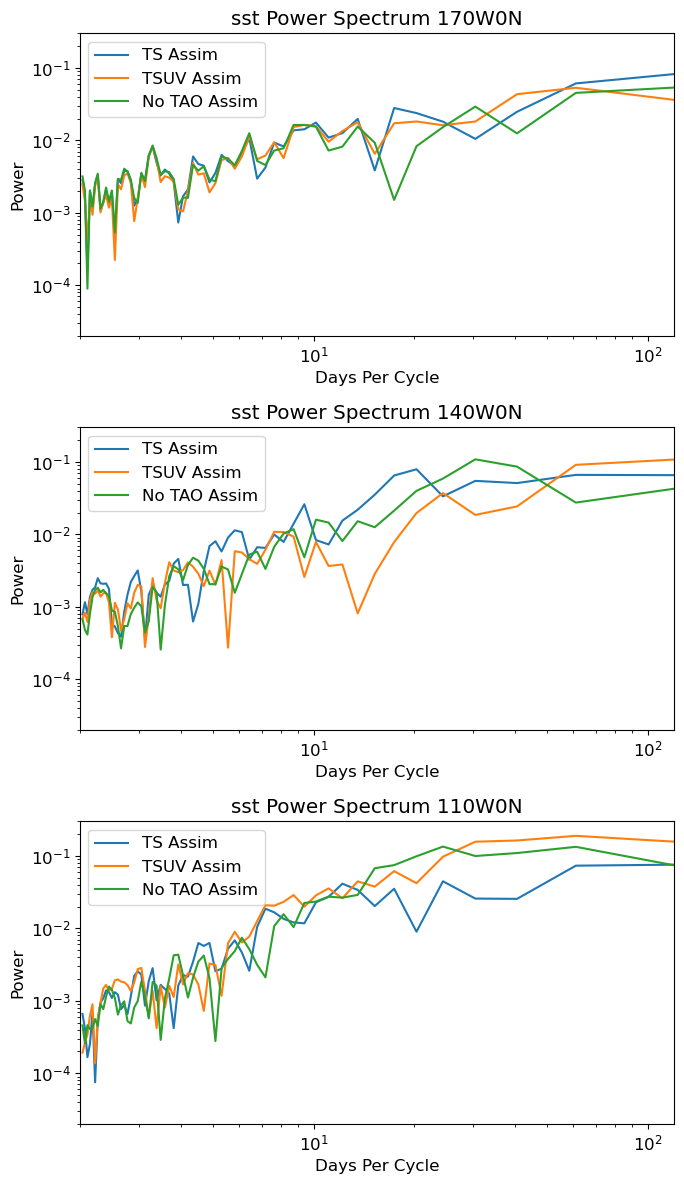

In [16]:
plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(figsize=(7,12), nrows=3)

labels = ['170W','140W','110W']

for i in range(3):
    amp1[:,i].plot(x='time',ax=ax[i],label='TS Assim')
    amp2[:,i].plot(x='time',ax=ax[i],label='TSUV Assim')
    amp3[:,i].plot(x='time',ax=ax[i],label='No TAO Assim')
    # (amp1 - amp2).plot(x='time',ax=ax,label='Difference',linestyle='--')
    ax[i].set_xlabel('Days Per Cycle')
    ax[i].set_ylabel('Power')
    ax[i].legend()
    ax[i].set_title('sst Power Spectrum ' + labels[i] + '0N')
    ax[i].axhline(0,color='k',linewidth=1)
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].set_ylim(2e-5,3e-1)
    ax[i].set_xlim(2,120)

plt.tight_layout()
plt.show()

fig.savefig(folder_name+'sst_spectrum_1D_0N.png')

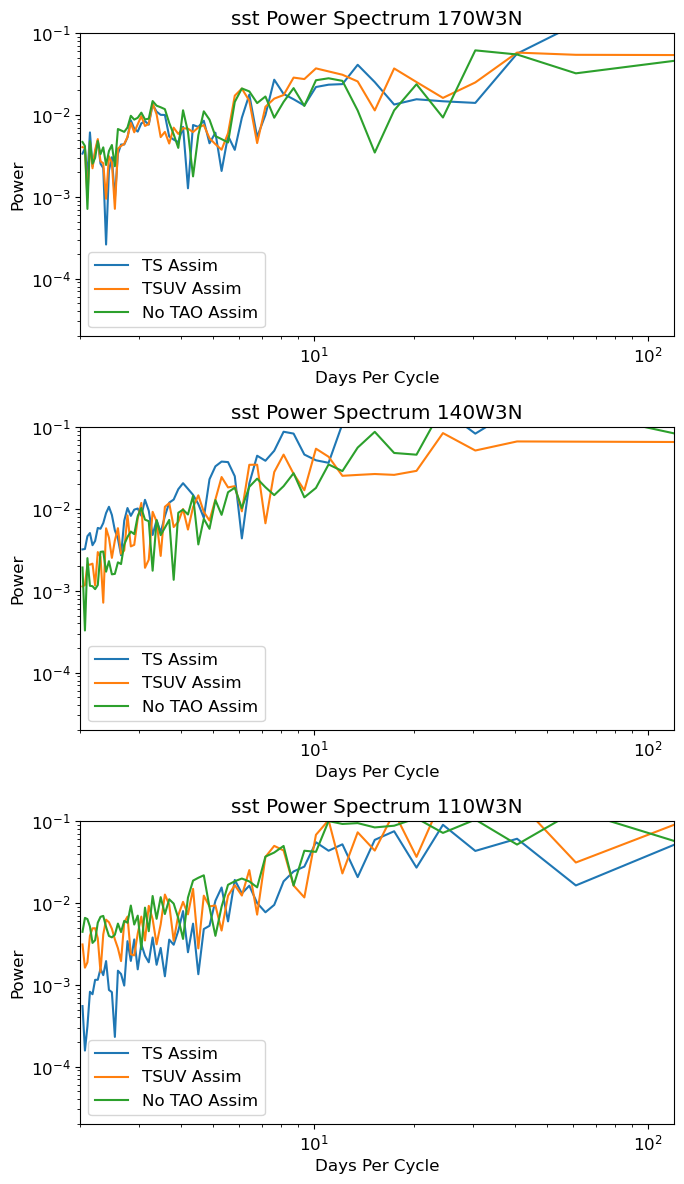

In [17]:
sst = ds.THETA.sel(Z=[0.0],XC=[190.0,220.0,250.0],method='nearest').sel(YC=[3.0],method='nearest').squeeze().compute()
sst_vel = ds_vel.THETA.sel(Z=[0.0],XC=[190.0,220.0,250.0],method='nearest').sel(YC=[3.0],method='nearest').squeeze().compute()
sst_noTAO = ds_noTAO.THETA.sel(Z=[0.0],XC=[190.0,220.0,250.0],method='nearest').sel(YC=[3.0],method='nearest').squeeze().compute()

sst_detrend = detrend(sst,axis=0,type='linear') 
sst_anom = sst_detrend - np.nanmean(sst_detrend,axis=0)
sst_vel_detrend = detrend(sst_vel,axis=0,type='linear') 
sst_vel_anom = sst_vel_detrend - np.nanmean(sst_vel_detrend,axis=0)
sst_noTAO_detrend = detrend(sst_noTAO,axis=0,type='linear')
sst_noTAO_anom = sst_noTAO_detrend - np.nanmean(sst_noTAO_detrend,axis=0)

N = len(sst.time)
window = np.hanning(N)*np.ones((3,1))

sst_window = sst_anom*window.T
Fsst = np.fft.fft(sst_window,axis=0)
amp1 = abs(Fsst[:N//2,:]/N)
amp1[1:,:] = 2*amp1[1:,:]
freq_segments = 1/(np.arange(N//2)/N)

sst_vel_window = sst_vel_anom*window.T
Fsst = np.fft.fft(sst_vel_window,axis=0)
amp2 = abs(Fsst[:N//2,:]/N)
amp2[1:,:] = 2*amp2[1:,:]

sst_noTAO_window = sst_noTAO_anom*window.T
Fsst = np.fft.fft(sst_noTAO_window,axis=0)
amp3 = abs(Fsst[:N//2,:]/N)
amp3[1:,:] = 2*amp3[1:,:]

temp = sst[:len(freq_segments)].copy(deep=True)
temp.values = amp1
amp1 = temp
amp1['time'] = freq_segments
amp1['long_name'] = 'sst Power Spectrum'
amp1 = amp1.isel(time=slice(1,None)) # get rid of the zero frequency

temp = sst_vel[:len(freq_segments)].copy(deep=True)
temp.values = amp2
amp2 = temp
amp2['time'] = freq_segments
amp2['long_name'] = 'sst Vel Assim Power Spectrum'
amp2 = amp2.isel(time=slice(1,None)) # get rid of the zero frequency

temp = sst_noTAO[:len(freq_segments)].copy(deep=True)
temp.values = amp3
temp['time'] = freq_segments
temp['long_name'] = 'sst No TAO Power Spectrum'
amp3 = temp
amp3 = amp3.isel(time=slice(1,None)) # get rid of the zero frequency

plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(figsize=(7,12), nrows=3)

labels = ['170W','140W','110W']

for i in range(3):
    amp1[:,i].plot(x='time',ax=ax[i],label='TS Assim')
    amp2[:,i].plot(x='time',ax=ax[i],label='TSUV Assim')
    amp3[:,i].plot(x='time',ax=ax[i],label='No TAO Assim')
    # (amp1 - amp2).plot(x='time',ax=ax,label='Difference',linestyle='--')
    ax[i].set_xlabel('Days Per Cycle')
    ax[i].set_ylabel('Power')
    ax[i].legend()
    ax[i].set_title('sst Power Spectrum ' + labels[i] + '3N')
    ax[i].axhline(0,color='k',linewidth=1)
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].set_ylim(2e-5,1e-1)
    ax[i].set_xlim(2,120)

plt.tight_layout()
plt.show()

fig.savefig(folder_name+'sst_spectrum_1D_3N.png')


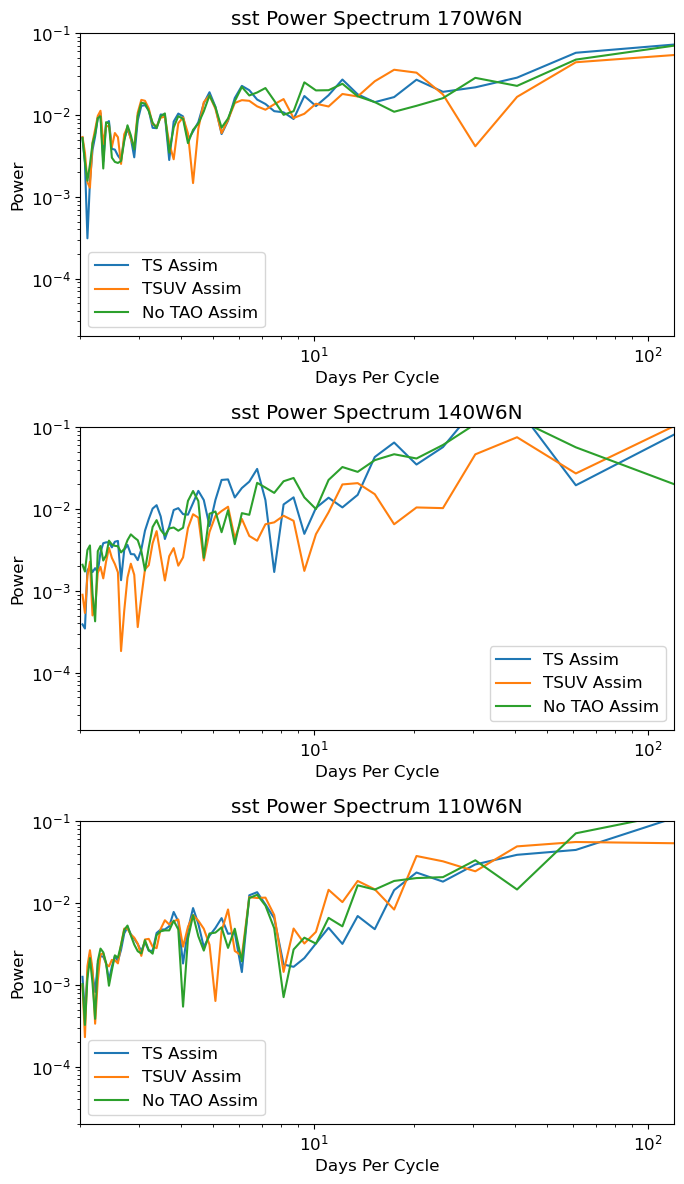

In [18]:
sst = ds.THETA.sel(Z=[0.0],XC=[190.0,220.0,250.0],method='nearest').sel(YC=[6.0],method='nearest').squeeze().compute()
sst_vel = ds_vel.THETA.sel(Z=[0.0],XC=[190.0,220.0,250.0],method='nearest').sel(YC=[6.0],method='nearest').squeeze().compute()
sst_noTAO = ds_noTAO.THETA.sel(Z=[0.0],XC=[190.0,220.0,250.0],method='nearest').sel(YC=[6.0],method='nearest').squeeze().compute()
sst_detrend = detrend(sst,axis=0,type='linear') 
sst_anom = sst_detrend - np.nanmean(sst_detrend,axis=0)
sst_vel_detrend = detrend(sst_vel,axis=0,type='linear') 
sst_vel_anom = sst_vel_detrend - np.nanmean(sst_vel_detrend,axis=0)
sst_noTAO_detrend = detrend(sst_noTAO,axis=0,type='linear')
sst_noTAO_anom = sst_noTAO_detrend - np.nanmean(sst_noTAO_detrend,axis=0)

N = len(sst.time)
window = np.hanning(N)*np.ones((3,1))

sst_window = sst_anom*window.T
Fsst = np.fft.fft(sst_window,axis=0)
amp1 = abs(Fsst[:N//2,:]/N)
amp1[1:,:] = 2*amp1[1:,:]
freq_segments = 1/(np.arange(N//2)/N)

sst_vel_window = sst_vel_anom*window.T
Fsst = np.fft.fft(sst_vel_window,axis=0)
amp2 = abs(Fsst[:N//2,:]/N)
amp2[1:,:] = 2*amp2[1:,:]

sst_noTAO_window = sst_noTAO_anom*window.T
Fsst = np.fft.fft(sst_noTAO_window,axis=0)
amp3 = abs(Fsst[:N//2,:]/N)
amp3[1:,:] = 2*amp3[1:,:]

temp = sst[:len(freq_segments)].copy(deep=True)
temp.values = amp1
amp1 = temp
amp1['time'] = freq_segments
amp1['long_name'] = 'sst Power Spectrum'
amp1 = amp1.isel(time=slice(1,None)) # get rid of the zero frequency

temp = sst_vel[:len(freq_segments)].copy(deep=True)
temp.values = amp2
amp2 = temp
amp2['time'] = freq_segments
amp2['long_name'] = 'sst Vel Assim Power Spectrum'
amp2 = amp2.isel(time=slice(1,None)) # get rid of the zero frequency

temp = sst_noTAO[:len(freq_segments)].copy(deep=True)
temp.values = amp3
temp['time'] = freq_segments
temp['long_name'] = 'sst No TAO Power Spectrum'
amp3 = temp
amp3 = amp3.isel(time=slice(1,None)) # get rid of the zero frequency

plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(figsize=(7,12), nrows=3)

labels = ['170W','140W','110W']

for i in range(3):
    amp1[:,i].plot(x='time',ax=ax[i],label='TS Assim')
    amp2[:,i].plot(x='time',ax=ax[i],label='TSUV Assim')
    amp3[:,i].plot(x='time',ax=ax[i],label='No TAO Assim')
    # (amp1 - amp2).plot(x='time',ax=ax,label='Difference',linestyle='--')
    ax[i].set_xlabel('Days Per Cycle')
    ax[i].set_ylabel('Power')
    ax[i].legend()
    ax[i].set_title('sst Power Spectrum ' + labels[i] + '6N')
    ax[i].axhline(0,color='k',linewidth=1)
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].set_ylim(2e-5,1e-1)
    ax[i].set_xlim(2,120)

plt.tight_layout()
plt.show()

fig.savefig(folder_name+'sst_spectrum_1D_6N.png')


### Frequency By Longitude (Avg over -5 to 5N)

In [22]:
lonMin = 180.0
lonMax = 260.0
latMin = -5
latMax = 5

sst = ds.THETA.sel(Z=[0.0],method='nearest').sel(XC=slice(lonMin,lonMax),YC=slice(latMin,latMax)).squeeze().mean(dim='YC').compute()
sst_vel = ds_vel.THETA.sel(Z=[0.0],method='nearest').sel(XC=slice(lonMin,lonMax),YC=slice(latMin,latMax)).squeeze().mean(dim='YC').compute()
sst_noTAO = ds_noTAO.THETA.sel(Z=[0.0],method='nearest').sel(XC=slice(lonMin,lonMax),YC=slice(latMin,latMax)).squeeze().mean(dim='YC').compute()

# detrend, get anomaly
sst_detrend = detrend(sst,axis=0,type='linear') 
sst_anom = sst_detrend - np.nanmean(sst_detrend,axis=0)
sst_vel_detrend = detrend(sst_vel,axis=0,type='linear') 
sst_vel_anom = sst_vel_detrend - np.nanmean(sst_vel_detrend,axis=0)
sst_noTAO_detrend = detrend(sst_noTAO,axis=0,type='linear')
sst_noTAO_anom = sst_noTAO_detrend - np.nanmean(sst_noTAO_detrend,axis=0)

N = len(sst.time)
window = np.hanning(N)*np.ones((len(sst.XC),1))

sst_window = sst_anom*window.T
Fsst = np.fft.fft(sst_window,axis=0)
amp1 = abs(Fsst[:N//2,:]/N)
amp1[1:,:] = 2*amp1[1:,:]
freq_segments = 1/(np.arange(N//2)/N)

sst_vel_window = sst_vel_anom*window.T
Fsst = np.fft.fft(sst_vel_window,axis=0)
amp2 = abs(Fsst[:N//2,:]/N)
amp2[1:,:] = 2*amp2[1:,:]

sst_noTAO_window = sst_noTAO_anom*window.T
Fsst = np.fft.fft(sst_noTAO_window,axis=0)
amp3 = abs(Fsst[:N//2,:]/N)
amp3[1:,:] = 2*amp3[1:,:]

temp = sst[:len(freq_segments)].copy(deep=True)
temp.values = amp1
amp1 = temp
amp1['time'] = freq_segments
amp1['long_name'] = 'sst Power Spectrum'
amp1 = amp1.isel(time=slice(1,None)) # get rid of the zero frequency

temp = sst_vel[:len(freq_segments)].copy(deep=True)
temp.values = amp2
amp2 = temp
amp2['time'] = freq_segments
amp2['long_name'] = 'sst Vel Assim Power Spectrum'
amp2 = amp2.isel(time=slice(1,None)) # get rid of the zero frequency

temp = sst_noTAO[:len(freq_segments)].copy(deep=True)
temp.values = amp3
temp['time'] = freq_segments
temp['long_name'] = 'sst No TAO Power Spectrum'
amp3 = temp
amp3 = amp3.isel(time=slice(1,None)) # get rid of the zero frequency



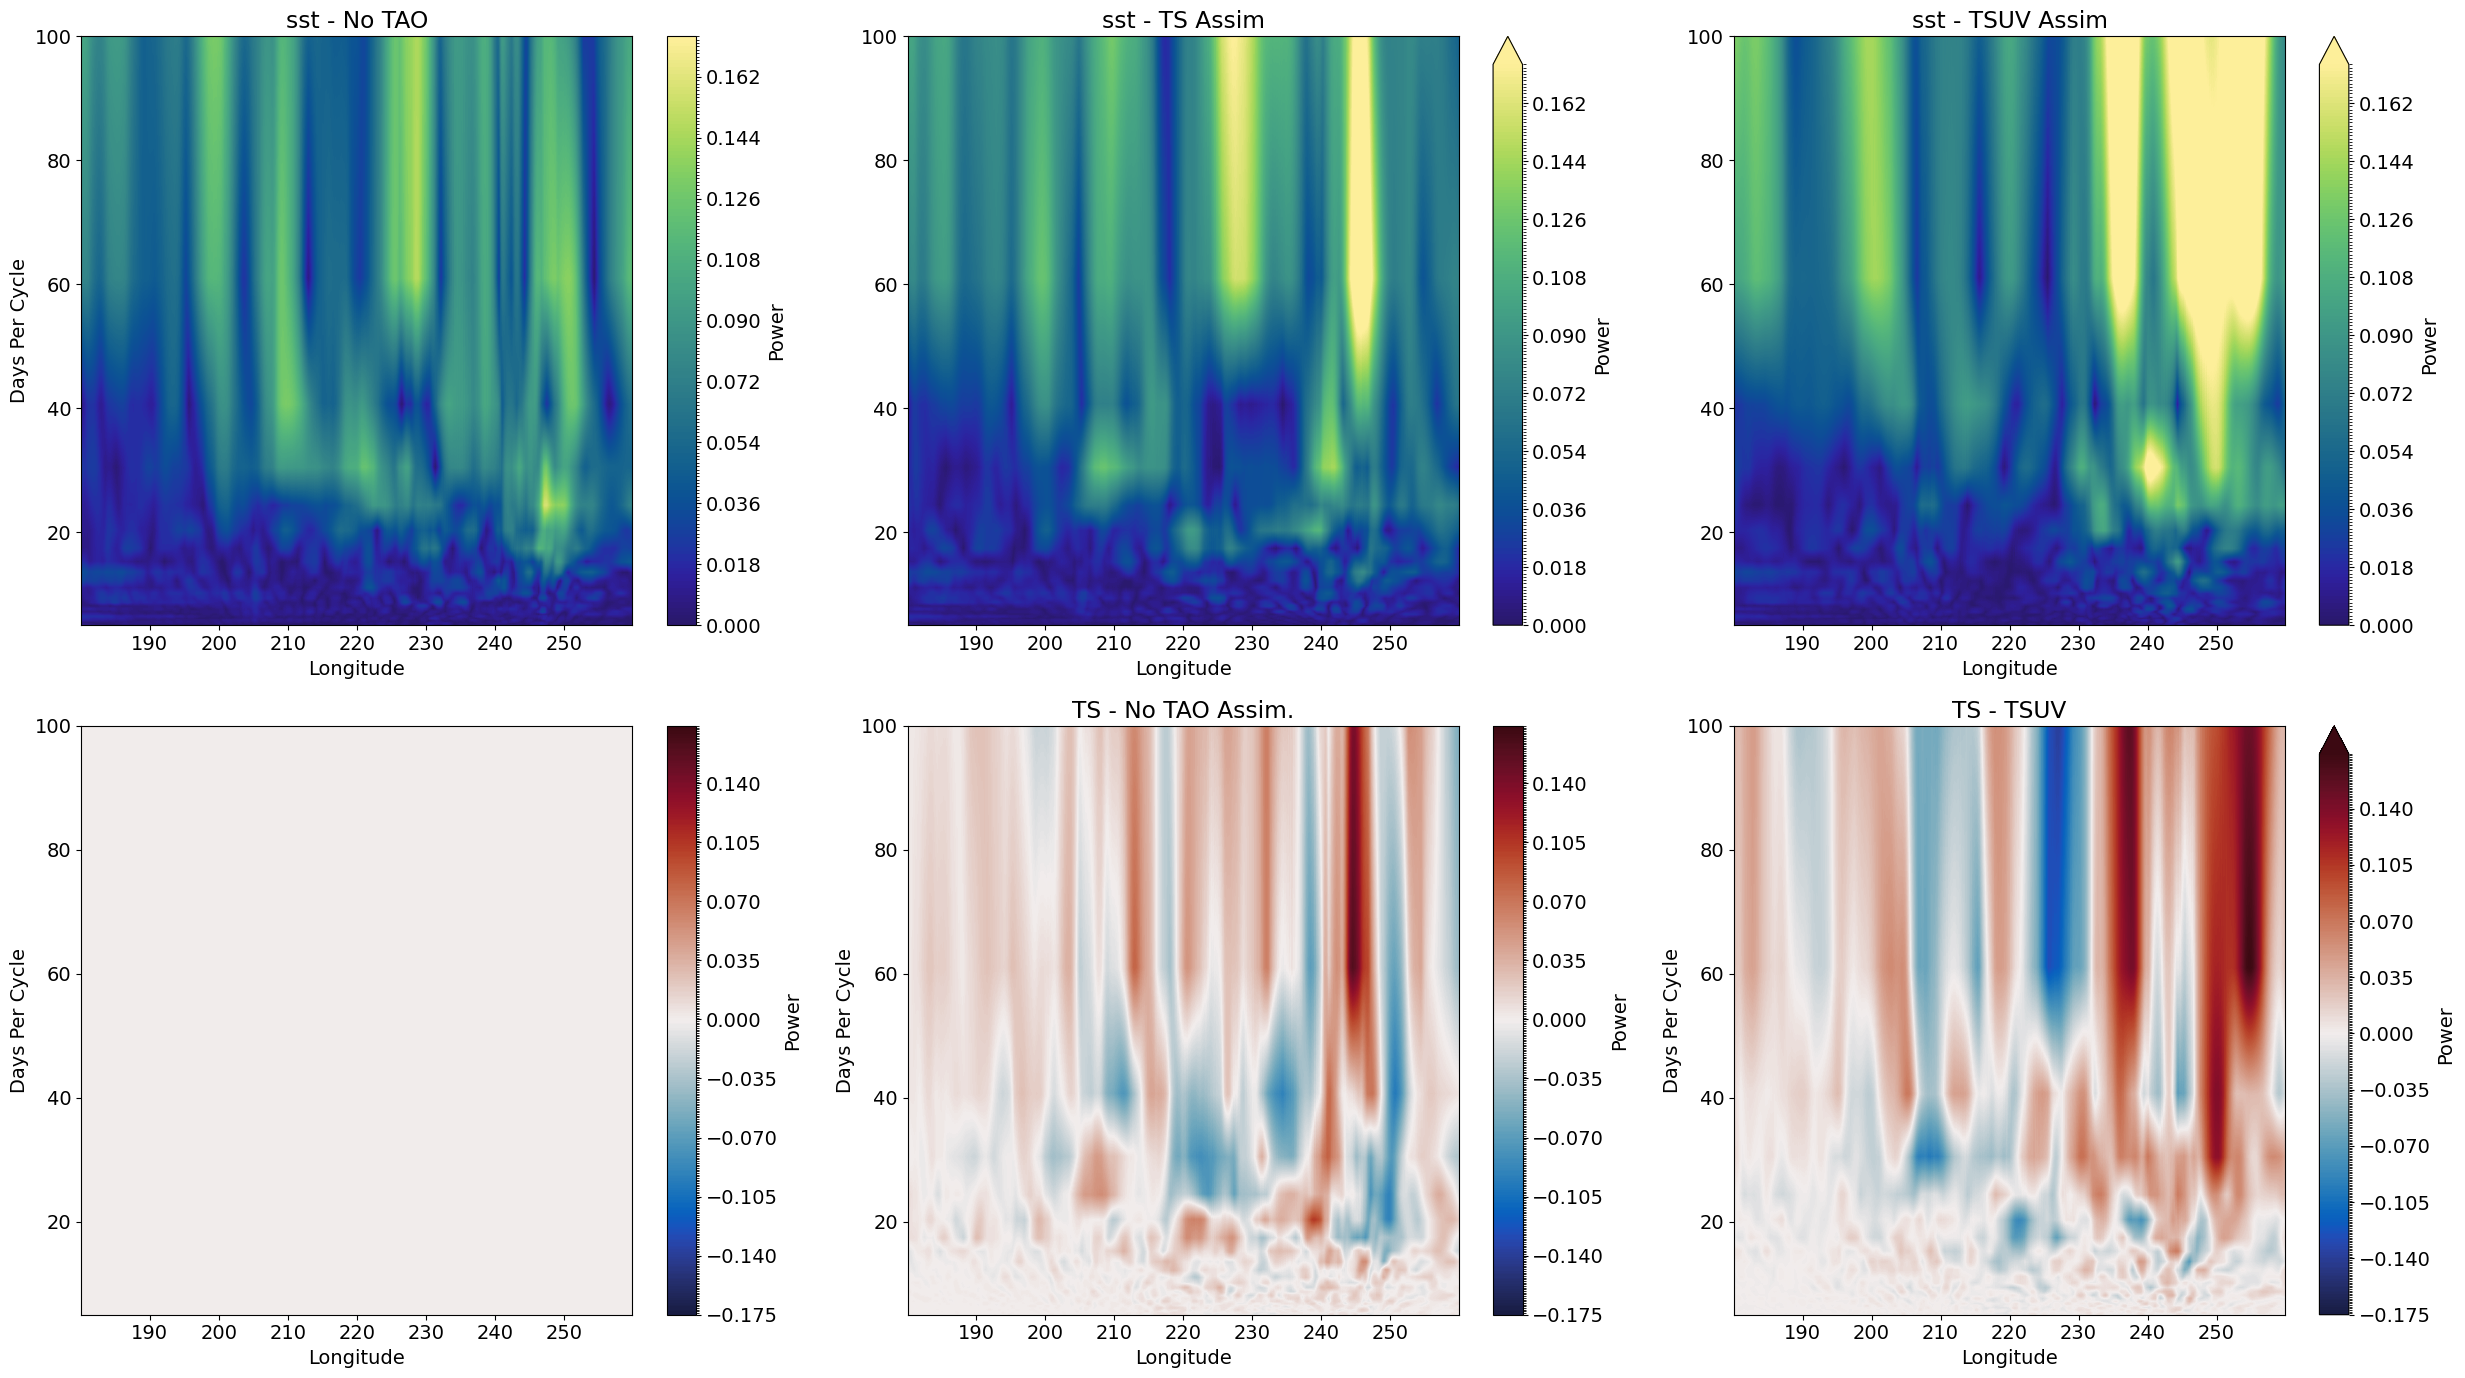

In [23]:
from matplotlib.colors import LogNorm   
plt.rcParams['font.size'] = 14

fig, ax = plt.subplots(ncols=3, nrows=2,figsize=(25,14))
levels = np.arange(1e-6,1.75e-1,1e-3)
amp3.plot.contourf(levels=levels,y='time',x='XC',ax=ax[0,0],cmap=cmo.haline,cbar_kwargs={'label': 'Power'})
ax[0,0].set_xlabel('Longitude')
ax[0,0].set_ylabel('Days Per Cycle')
ax[0,0].set_ylim(5,100)  
ax[0,0].set_title('sst - No TAO')

amp1.plot.contourf(levels=levels,y='time',x='XC',ax=ax[0,1],cmap=cmo.haline,cbar_kwargs={'label': 'Power'})
ax[0,1].set_xlabel('Longitude')
ax[0,1].set_ylabel('')
ax[0,1].set_ylim(5,100)  
ax[0,1].set_title('sst - TS Assim')

amp2.plot.contourf(levels=levels,y='time',x='XC',ax=ax[0,2],cmap=cmo.haline,cbar_kwargs={'label': 'Power'})
ax[0,2].set_xlabel('Longitude')
ax[0,2].set_ylabel('')
ax[0,2].set_ylim(5,100)  
ax[0,2].set_title('sst - TSUV Assim')

levels = np.arange(-1.75e-1,1.75e-1,1e-3)
(amp3 - amp3).plot.contourf(levels=levels,y='time',x='XC',ax=ax[1,0],cmap=cmo.balance,cbar_kwargs={'label': 'Power'})
ax[1,0].set_xlabel('Longitude')
ax[1,0].set_ylabel('Days Per Cycle')
ax[1,0].set_ylim(5,100)  
ax[1,0].set_title('')

(amp1 - amp3).plot.contourf(levels=levels,y='time',x='XC',ax=ax[1,1],cmap=cmo.balance,cbar_kwargs={'label': 'Power'})
ax[1,1].set_xlabel('Longitude')
ax[1,1].set_ylabel('Days Per Cycle')
ax[1,1].set_ylim(5,100)  
ax[1,1].set_title('TS - No TAO Assim.')

(amp2 - amp1).plot.contourf(levels=levels,y='time',x='XC',ax=ax[1,2],cmap=cmo.balance,cbar_kwargs={'label': 'Power'})
ax[1,2].set_xlabel('Longitude')
ax[1,2].set_ylabel('Days Per Cycle')
ax[1,2].set_ylim(5,100)  
ax[1,2].set_title('TS - TSUV')

plt.tight_layout()
plt.show()

fig.savefig(folder_name+'sst_spectrum_byLon.png')

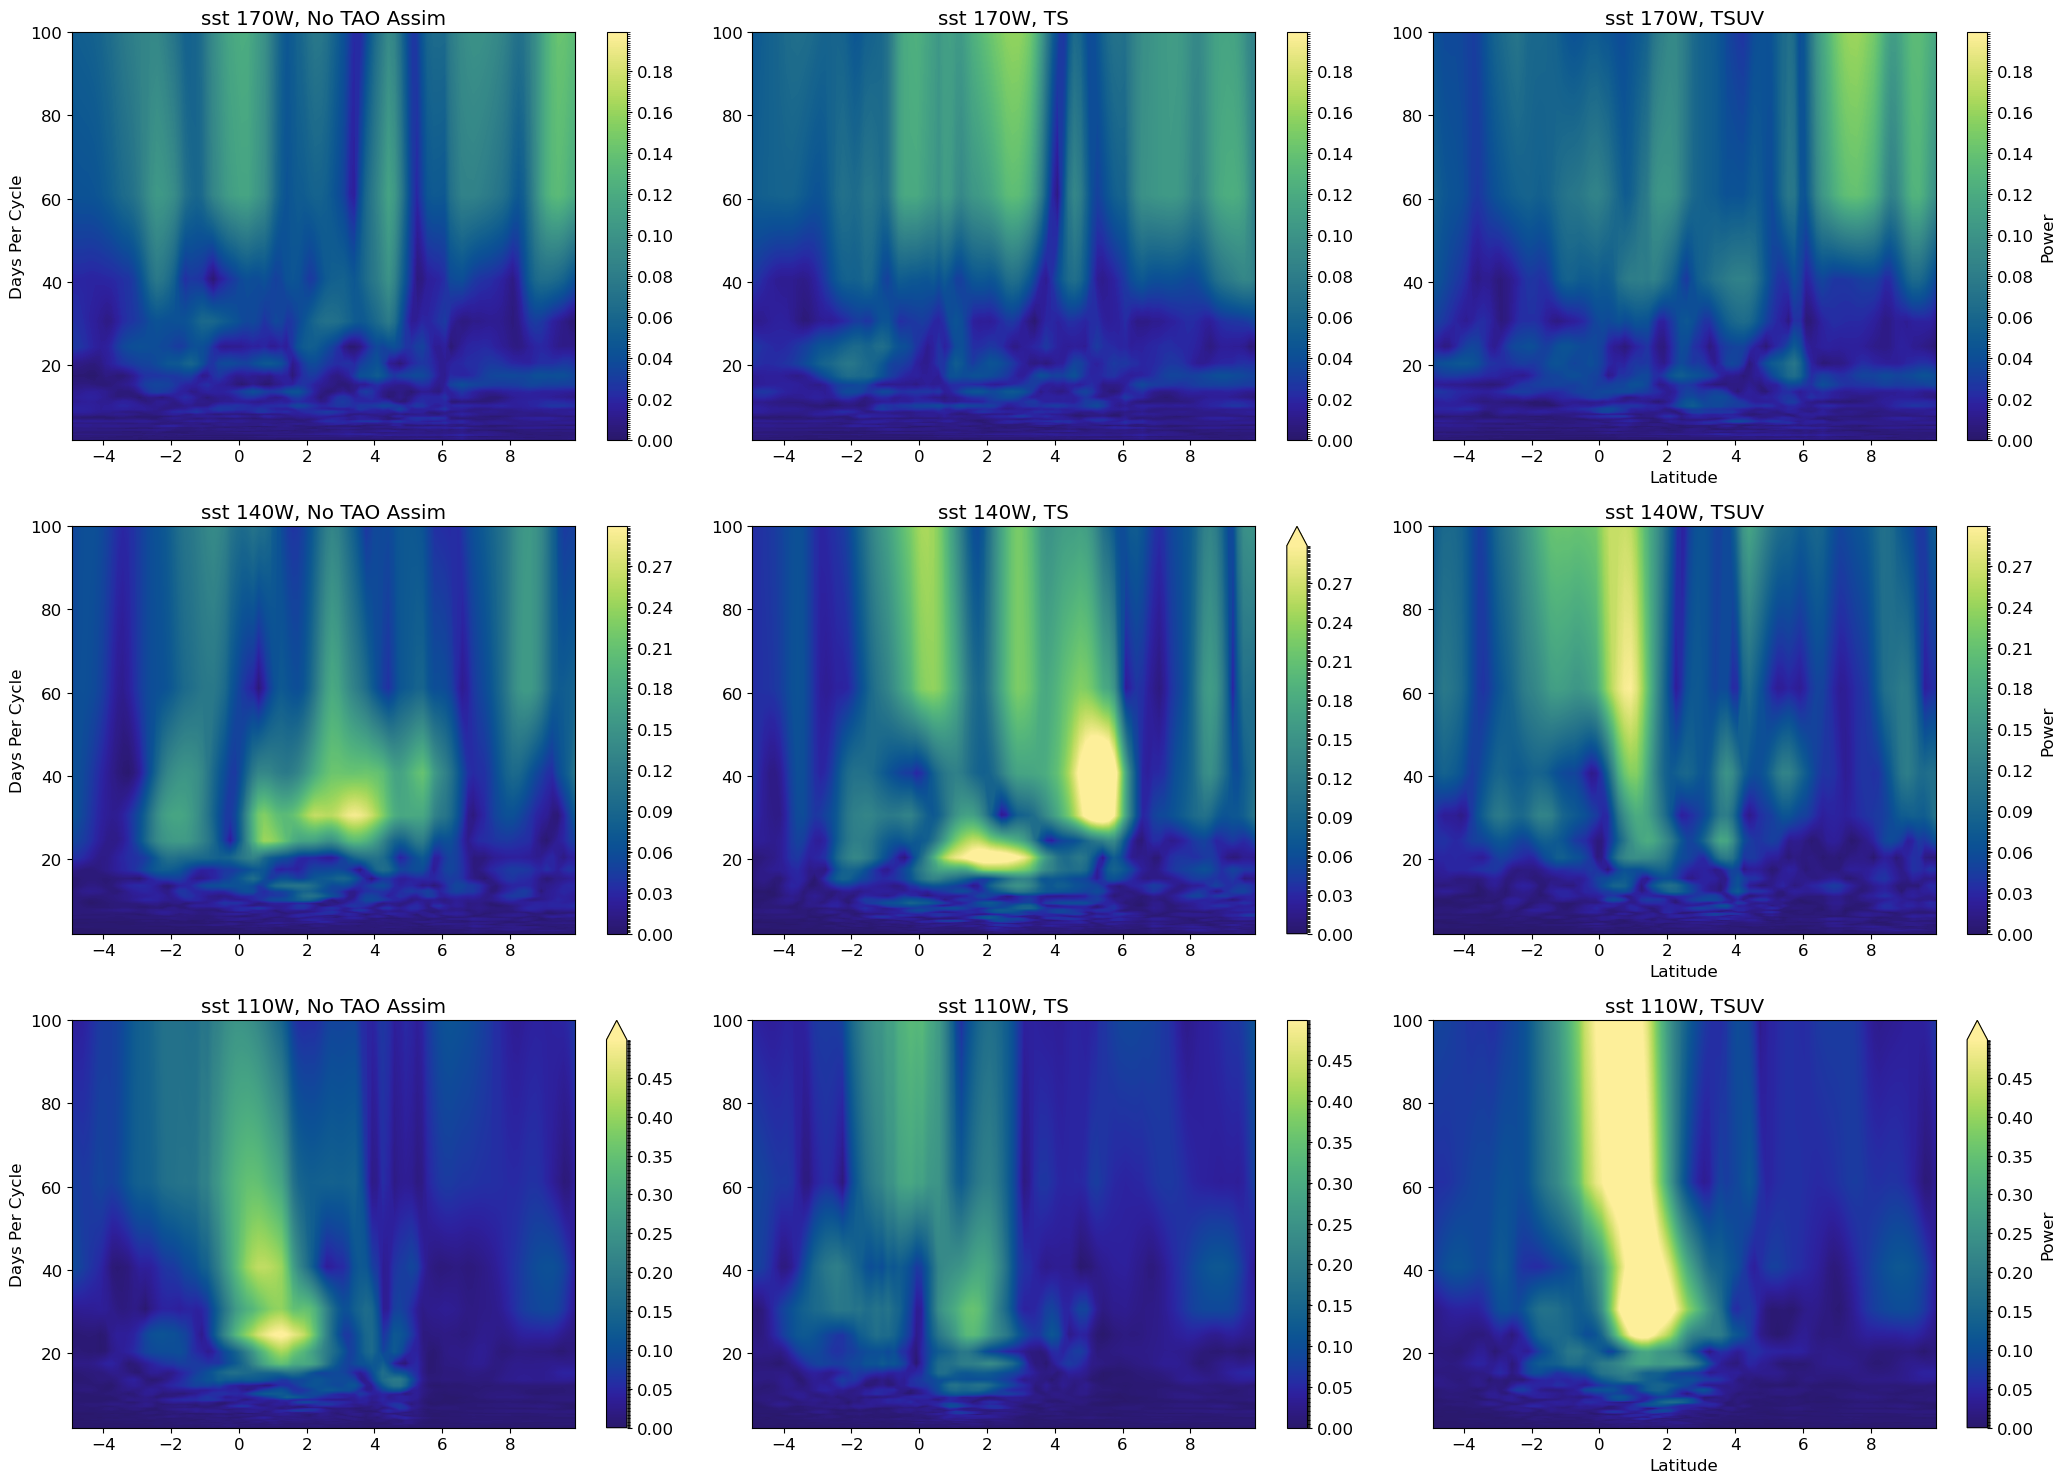

In [31]:
### Frequency By Latitude (at 3 Longtidues)

sst = ds.THETA.sel(Z=[0.0],method='nearest').sel(XC=[190.0,220.0,250.0],method='nearest').sel(YC=slice(-5,10)).squeeze().compute()
sst_vel = ds_vel.THETA.sel(Z=[0.0],method='nearest').sel(XC=[190.0,220.0,250.0],method='nearest').sel(YC=slice(-5,10)).squeeze().compute()
sst_noTAO = ds_noTAO.THETA.sel(Z=[0.0],method='nearest').sel(XC=[190.0,220.0,250.0],method='nearest').sel(YC=slice(-5,10)).squeeze().compute()

sst_detrend = detrend(sst,axis=0,type='linear') 
sst_anom = sst_detrend - np.nanmean(sst_detrend,axis=0)
sst_vel_detrend = detrend(sst_vel,axis=0,type='linear') 
sst_vel_anom = sst_vel_detrend - np.nanmean(sst_vel_detrend,axis=0)
sst_noTAO_detrend = detrend(sst_noTAO,axis=0,type='linear')
sst_noTAO_anom = sst_noTAO_detrend - np.nanmean(sst_noTAO_detrend,axis=0)

N = len(sst.time)
window = np.hanning(N)*np.ones((3,len(sst.YC),1))

sst_window = sst_anom*window.T
Fsst = np.fft.fft(sst_window,axis=0)
amp1 = abs(Fsst[:N//2,:]/N)
amp1[1:,:] = 2*amp1[1:,:]
freq_segments = 1/(np.arange(N//2)/N)

sst_vel_window = sst_vel_anom*window.T
Fsst = np.fft.fft(sst_vel_window,axis=0)
amp2 = abs(Fsst[:N//2,:]/N)
amp2[1:,:] = 2*amp2[1:,:]

sst_noTAO_window = sst_noTAO_anom*window.T
Fsst = np.fft.fft(sst_noTAO_window,axis=0)
amp3 = abs(Fsst[:N//2,:]/N)
amp3[1:,:] = 2*amp3[1:,:]

temp = sst[:len(freq_segments)].copy(deep=True)
temp.values = amp1
amp1 = temp
amp1['time'] = freq_segments
amp1['long_name'] = 'sst Power Spectrum'
amp1 = amp1.isel(time=slice(1,None)) # get rid of the zero frequency

temp = sst_vel[:len(freq_segments)].copy(deep=True)
temp.values = amp2
amp2 = temp
amp2['time'] = freq_segments
amp2['long_name'] = 'sst Vel Assim Power Spectrum'
amp2 = amp2.isel(time=slice(1,None)) # get rid of the zero frequency

temp = sst_noTAO[:len(freq_segments)].copy(deep=True)
temp.values = amp3
temp['time'] = freq_segments
temp['long_name'] = 'sst No TAO Power Spectrum'
amp3 = temp
amp3 = amp3.isel(time=slice(1,None)) # get rid of the zero frequency

plt.rcParams['font.size'] = 12

labels = ['170W','140W','110W']
fig, ax = plt.subplots(figsize=(21,15), nrows=3, ncols=3)

levels = [np.arange(1e-6,2e-1,1e-3), np.arange(1e-6,3e-1,1e-3), np.arange(1e-6,5e-1,1e-3)]
for i in range(3):
    amp3[:,:,i].plot.contourf(levels=levels[i],y='time',x='YC',ax=ax[i,0],cmap=cmo.haline,cbar_kwargs={'label': ''})
    ax[i,0].set_ylabel('Days Per Cycle')
    ax[i,0].set_xlabel('')
    ax[i,0].set_title('sst ' + labels[i]  + ', No TAO Assim')
    ax[i,0].set_ylim(2,100)

for i in range(3):
    amp1[:,:,i].plot.contourf(levels=levels[i],y='time',x='YC',ax=ax[i,1],cmap=cmo.haline,cbar_kwargs={'label': ''})
    ax[i,1].set_ylabel('')
    ax[i,1].set_xlabel('')
    ax[i,1].set_title('sst ' + labels[i] + ', TS')
    ax[i,1].set_ylim(2,100)

for i in range(3):
    amp2[:,:,i].plot.contourf(levels=levels[i],y='time',x='YC',ax=ax[i,2],cmap=cmo.haline,cbar_kwargs={'label': 'Power'})
    ax[i,2].set_ylabel('')
    ax[i,2].set_xlabel('Latitude')
    ax[i,2].set_title('sst ' + labels[i] + ', TSUV')
    ax[i,2].set_ylim(2,100)

plt.tight_layout()
plt.show()

fig.savefig(folder_name+'sst_spectrum_byLat.png')


### SST Variance

In [35]:
sst_mean = ds.THETA.sel(Z=[0.0],method='nearest').sel(YC=slice(-20,20)).squeeze().mean(dim='time').compute()
sst_var = ds.THETA.sel(Z=[0.0],method='nearest').sel(YC=slice(-20,20)).squeeze().var(dim='time').compute()

sst_vel_mean = ds_vel.THETA.sel(Z=[0.0],method='nearest').sel(YC=slice(-20,20)).squeeze().mean(dim='time').compute()
sst_vel_var = ds_vel.THETA.sel(Z=[0.0],method='nearest').sel(YC=slice(-20,20)).squeeze().var(dim='time').compute()

sst_noTAO_mean = ds_noTAO.THETA.sel(Z=[0.0],method='nearest').sel(YC=slice(-20,20)).squeeze().mean(dim='time').compute()
sst_noTAO_var = ds_noTAO.THETA.sel(Z=[0.0],method='nearest').sel(YC=slice(-20,20)).squeeze().var(dim='time').compute()

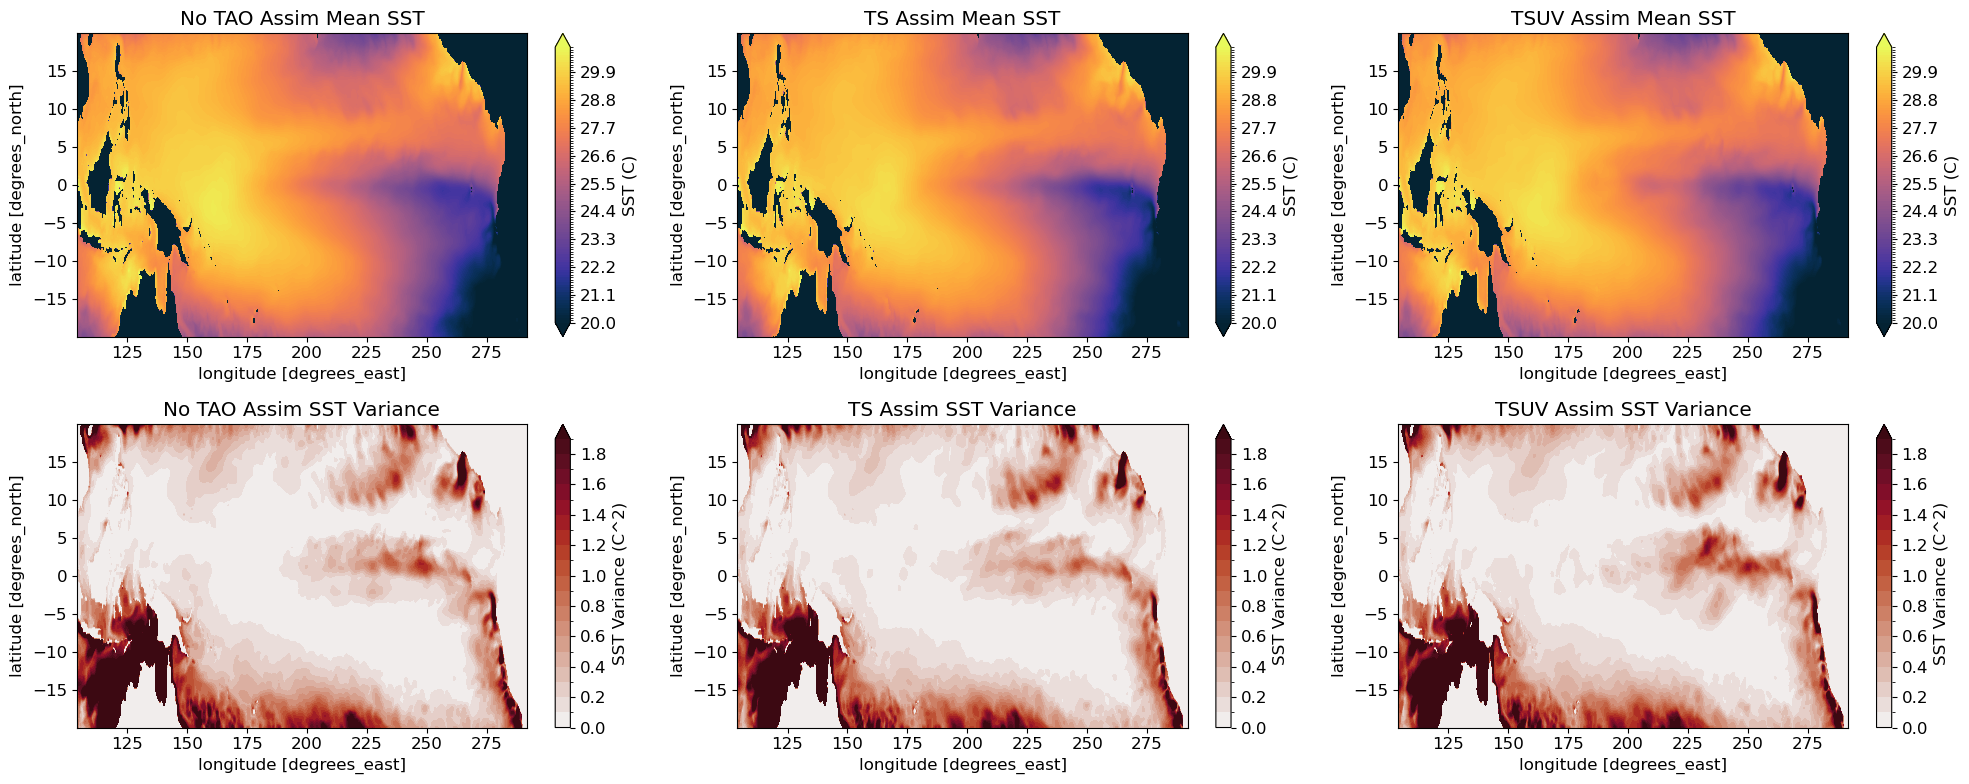

In [37]:
fig,ax = plt.subplots(ncols=3, nrows=2, figsize=(20,8))
levels = np.arange(20,31,0.1)
sst_noTAO_mean.plot.contourf(levels=levels,x='XC',y='YC',ax=ax[0,0],cmap=cmo.thermal,cbar_kwargs={'label': 'SST (C)'})
ax[0,0].set_title('No TAO Assim Mean SST')
sst_mean.plot.contourf(levels=levels,x='XC',y='YC',ax=ax[0,1],cmap=cmo.thermal,cbar_kwargs={'label': 'SST (C)'})
ax[0,1].set_title('TS Assim Mean SST')
sst_vel_mean.plot.contourf(levels=levels,x='XC',y='YC',ax=ax[0,2],cmap=cmo.thermal,cbar_kwargs={'label': 'SST (C)'})
ax[0,2].set_title('TSUV Assim Mean SST')
levels = np.arange(0,2,0.1)
sst_noTAO_var.plot.contourf(levels=levels,x='XC',y='YC',ax=ax[1,0],cmap=cmo.amp,cbar_kwargs={'label': 'SST Variance (C^2)'})
ax[1,0].set_title('No TAO Assim SST Variance')
sst_var.plot.contourf(levels=levels,x='XC',y='YC',ax=ax[1,1],cmap=cmo.amp,cbar_kwargs={'label': 'SST Variance (C^2)'})
ax[1,1].set_title('TS Assim SST Variance')
sst_vel_var.plot.contourf(levels=levels,x='XC',y='YC',ax=ax[1,2],cmap=cmo.amp,cbar_kwargs={'label': 'SST Variance (C^2)'})
ax[1,2].set_title('TSUV Assim SST Variance')

plt.tight_layout()
fig.savefig(folder_name+'sst_mean_var.png')

#### Shutdown

In [38]:
cluster.close()
client.shutdown()
client.close()